In [2]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

from os import path
from acoular import __file__ as bpath, MicGeom, WNoiseGenerator, PointSource,\
 Mixer, WriteH5, TimeSamples, PowerSpectra, RectGrid, SteeringVector,\
 BeamformerBase, BeamformerFunctional, BeamformerMusic, L_p, SineGenerator
from pylab import figure, plot, axis, imshow, colorbar, show


# set up the parameters
sfreq = 51200 
duration = 5
nsamples = duration*sfreq
micgeofile = 'array_9.xml'
h5savefile = 'noise_sine.h5'

# generate test data, in real life this would come from an array measurement
mg = MicGeom( from_file=micgeofile )
# n1 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=1 )
# n2 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=2 )
# n3 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=3, rms=1 )
n1 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=2000)
n2 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=4000)
n3 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=3, rms=1 )
n4 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=6, rms=0.7 )
n5 = WNoiseGenerator( sample_freq=sfreq, numsamples=nsamples, seed=7, rms=1 )

p1 = PointSource( signal=n1, mics=mg,  loc=(2,2,0.5) ) # noise 2k hz at center
p2 = PointSource( signal=n1, mics=mg,  loc=(4,2,0.5) ) # noise 2k hz at right
p3 = PointSource( signal=n2, mics=mg,  loc=(0,2,0.5) ) # signal 4k hz at left
p4 = PointSource( signal=n4, mics=mg,  loc=(4,4,0.5) ) # noise white at upper right
# p5 = PointSource( signal=n2, mics=mg,  loc=(0,2,0.5) ) # signal 4k hz at left
p6 = PointSource( signal=n5, mics=mg,  loc=(1,2,0.5) ) # noise white at center left
p7 = PointSource( signal=n3, mics=mg,  loc=(0,0,0.5) ) # noise white at lower left
p8 = PointSource( signal=n1, mics=mg,  loc=(4,0,0.5) ) # noise 2k at lower right
pa = Mixer( source=p1, sources=[p2, p4, p6, p7, p8] )
wh5 = WriteH5( source=pa, name=h5savefile )
wh5.save()

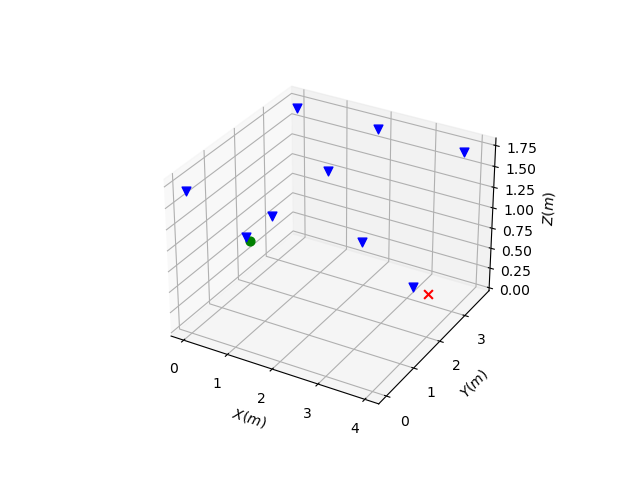

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from acoular import MicGeom

fig = plt.figure()
ax3 = plt.axes(projection='3d')

mg = MicGeom(from_file='array_9.xml')
number_of_mic = mg.mpos.shape[1]
MIC_POS = []
for i in np.arange(number_of_mic):
    ax3.scatter(mg.mpos[0,int(i)], mg.mpos[1,int(i)], mg.mpos[2,int(i)], s=40, c='b', marker='v')

# ax3.scatter(2, 2, 0.5, s=40, c='r', marker='x')
# ax3.scatter(4, 2, 0.5, s=40, c='r', marker='x')
ax3.scatter(0, 2, 0.5, s=40, c='g', marker='o')
# ax3.scatter(4, 4, 0.5, s=40, c='r', marker='8')
ax3.scatter(4, 2, 0.5, s=40, c='r', marker='x')
# ax3.scatter(1, 2, 0.5, s=40, c='r', marker='8')
# ax3.scatter(0, 0, 0.5, s=40, c='r', marker='8')
# ax3.scatter(4, 0, 0.5, s=40, c='r', marker='x')

ax3.set_xlabel('$X (m)$')
ax3.set_ylabel('$Y (m)$')
ax3.set_zlabel('$Z (m)$')
ax3.set_zlim(0, 1.8)

#ax3.contour(X,Y,Z, zdim='z',offset=-2，cmap='rainbow)   #等高线图，要设置offset，为Z的最小值
plt.show()

[('sine_wh_wh_8000_cache.h5', 3)]


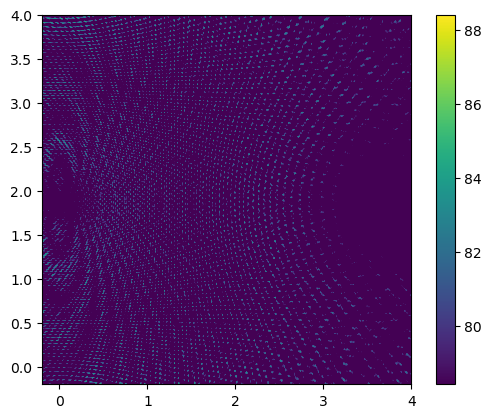

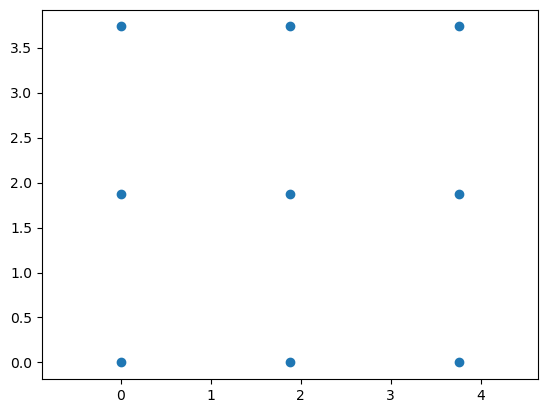

In [12]:
# analyze the data and generate map

ts = TimeSamples( name=h5savefile )
ps = PowerSpectra( time_data=ts, block_size=1024, window='Hanning' )

rg = RectGrid( x_min=-0.2, x_max=4,
                       y_min=-0.2, y_max=4,
                       z=0.5, increment=0.01 )
st = SteeringVector( grid=rg, mics=mg, steer_type='true location', ref=[1.88,1.87,1.68] )
bb = BeamformerBase( freq_data=ps, steer=st )
pm = bb.synthetic(8000,3)
Lm = L_p( pm )

# show map
imshow( Lm.T, origin='lower', vmin=Lm.max()-10, extent=rg.extend(), \
interpolation='bicubic')
colorbar()

# plot microphone geometry
figure(2)
plot(mg.mpos[0],mg.mpos[1],'o')
axis('equal')

show()